In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


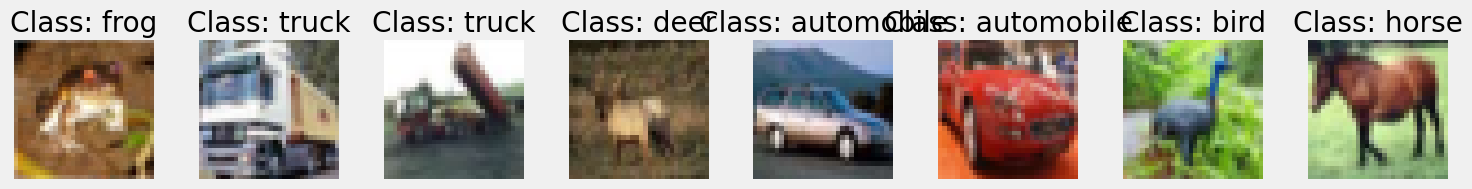

In [27]:
# CIFAR-10 Dataset
# Define transforms
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
    ]
)

# Alternative transform for [0, 1] range (matches Sigmoid output)
transform_01 = transforms.Compose(
    [
        transforms.ToTensor()  # Already converts to [0, 1]
    ]
)

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_01
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_01
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")


# Visualize some samples
def show_images(dataset, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Change from CHW to HWC
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


show_images(train_dataset)


# Auto Encoder 1: Without dim reduction

In [28]:
IMAGE_DIM = 32 * 32 * 3  # CIFAR-10 images are 32x32 with 3 color channels
LATENT_DIM = 9

In [29]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(IMAGE_DIM, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, LATENT_DIM),
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, IMAGE_DIM),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [30]:
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)


In [ ]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(-1, IMAGE_DIM).to(device)

        reconstructed = model(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


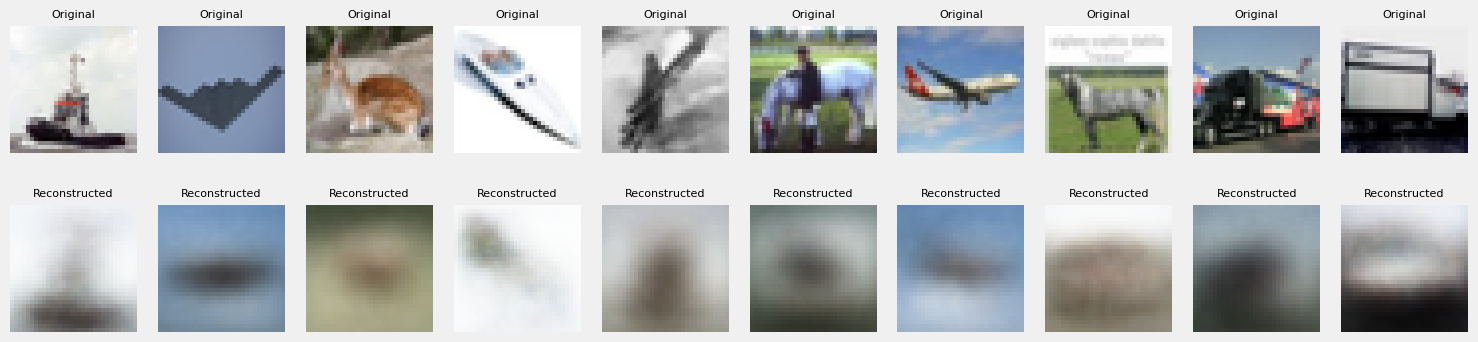

In [ ]:
model.eval()
dataiter = iter(train_loader)
images, _ = next(dataiter)

images = images.view(-1, IMAGE_DIM).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))
for i in range(10):
    # Original images
    img_original = images[i].cpu().detach().numpy().reshape(3, 32, 32)
    img_original = np.transpose(img_original, (1, 2, 0))  # Change from CHW to HWC
    axes[0, i].imshow(img_original)
    axes[0, i].axis("off")
    axes[0, i].set_title("Original", fontsize=8)
    
    # Reconstructed images
    img_reconstructed = reconstructed[i].cpu().detach().numpy().reshape(3, 32, 32)
    img_reconstructed = np.transpose(img_reconstructed, (1, 2, 0))  # Change from CHW to HWC
    axes[1, i].imshow(img_reconstructed)
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# I want to print the 